El notebook desarrollado implementa dos enfoques de modelado para series de tiempo: modelos clásicos de suavización exponencial (ETS) y el modelo estructural Prophet. Para ambos métodos se incorporan técnicas avanzadas de optimización bayesiana mediante Optuna, lo que permite explorar de forma eficiente el espacio de hiperparámetros y seleccionar las configuraciones que minimizan el error de pronóstico. Además, la evaluación de desempeño se realiza utilizando dos estrategias robustas de validación temporal: la validación con ventana recurrente (expanding window), donde el conjunto de entrenamiento crece progresivamente en cada iteración, y la validación con ventana móvil (rolling window), en la que el tamaño del entrenamiento es fijo y se desplaza a lo largo de la serie. Estas metodologías garantizan una comparación justa, estable y realista de los modelos, permitiendo identificar aquel con mejor capacidad predictiva bajo condiciones similares a las del uso real.

In [65]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np
import optuna
import numpy as np
import pandas as pd
import warnings
import optuna
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose  # descomposición de series
from statsmodels.tsa.holtwinters import SimpleExpSmoothing  # Holwinters simple
# Holwinters doble y tripe
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.metrics import mean_squared_error

In [66]:
# Importar funciones del notebook de utilidades
# Usamos %run para ejecutar el notebook completo y tener acceso a todas las funciones
%run ../utils/funcions.ipynb

# Verificar que la función está disponible
print("✓ Funciones importadas correctamente")

✓ Funciones importadas correctamente


In [67]:
# Carga de datos
# El archivo usa punto y coma como separador y coma como decimal
file_path = '../data/results/capacidad_acumulada_processed.csv'


df = load_capacidad_csv_data(file_path, sep=',', decimal='.')
df.tail()

,Fecha,SOLAR,EOLICA,PCH
76,2025-05-31,2904.185550,41.0,20.615945
77,2025-06-30,2905.793884,41.0,20.615945
78,2025-07-31,2907.402217,41.0,20.615945
79,2025-08-31,2909.382217,41.0,20.615945
80,2025-09-30,3079.000000,41.0,20.620000


In [68]:
df['Fecha'] = pd.to_datetime(df['Fecha'])   # convertir a fecha
df = df.set_index('Fecha')                  # usar como índice
df = df.asfreq('M')                         # asegurar frecuencia mensual

In [69]:
serie = df["SOLAR"].astype(float).sort_index()

In [70]:
serie.shape

(81,)

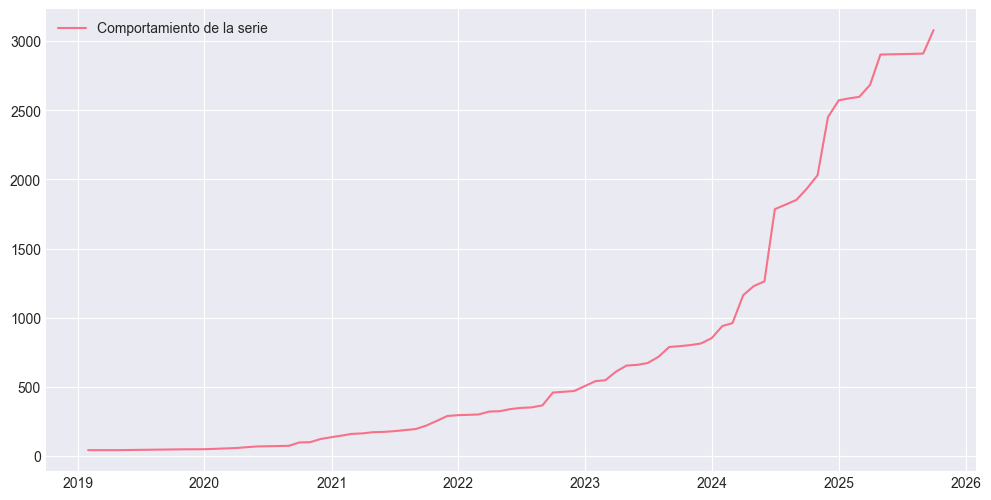

In [71]:
# visualizacion de los datos de la serie 
fig = plt.figure(figsize=(12, 6))
plt.plot(serie, label="Comportamiento de la serie")
plt.legend()
plt.show()

## **Función Entrenamiento ventana expandida y busqueda de mejores add, trend, seasonal, y sus respectivos Alpha, Beta y Gamma**

In [72]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
warnings.filterwarnings("ignore")
import math
# definimos la funcion de optimizacion con los hiper paramatros. damped hace referencia a la amortiguacion de la tendencia 
def rolling_hw_rmse(serie,
                    horizon,
                    initial_train_size,
                    error,
                    trend,
                    seasonal,
                    seasonal_periods,
                    alpha,
                    beta,
                    gamma,
                    damped):
    
    y = np.asarray(serie.dropna())
    n = len(y)
    errors = []

    if n <= initial_train_size + horizon:
        return float("inf")

    for end in range(initial_train_size, n - horizon + 1):

        train = y[:end]
        test  = y[end:end + horizon]

        try:
            model = ExponentialSmoothing(
                train,
                trend=trend,
                damped_trend=damped,
                seasonal=seasonal,
                seasonal_periods=seasonal_periods,
                initialization_method="estimated",
            )
            
            fit = model.fit(
                optimized=True,
                smoothing_level=alpha,
                smoothing_slope=beta if trend is not None else None,
                smoothing_seasonal=gamma if seasonal is not None else None,
            )

            fcst = fit.forecast(horizon)

            rmse = np.sqrt(np.mean((fcst - test) ** 2))
            if not math.isfinite(rmse):
                return float("inf")

            errors.append(rmse)

        except Exception:
            return float("inf")

    return float(np.mean(errors)) if errors else float("inf")


## **Optimización Bayesiana**

In [73]:
H = 10  # horizonte de predicción para llegar a 1 de Agosto de 2026

def objective(trial):

    # MODELOS
    trend = trial.suggest_categorical("trend", [None, "add", "mul"])
    seasonal = trial.suggest_categorical("seasonal", [None, "add", "mul"])

    seasonal_periods = None
    if seasonal is not None:
        seasonal_periods = trial.suggest_categorical("seasonal_periods", [6, 12])

    damped = trial.suggest_categorical("damped_trend", [False, True])

    # HIPERPARÁMETROS
    alpha = trial.suggest_float("alpha", 0.01, 0.99)
    beta  = trial.suggest_float("beta", 0.01, 0.99) if trend is not None else None
    gamma = trial.suggest_float("gamma", 0.01, 0.99) if seasonal is not None else None

    # tamaño inicial para ventana recursiva
    min_train = 36 if seasonal_periods is None else 3 * seasonal_periods

    rmse = rolling_hw_rmse(
        serie,
        horizon=H,
        initial_train_size=min_train,
        error=None,  # implícito por add/mul
        trend=trend,
        seasonal=seasonal,
        seasonal_periods=seasonal_periods,
        alpha=alpha,
        beta=beta,
        gamma=gamma,
        damped=damped,
    )

    return rmse


In [74]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=60, n_jobs=1)
rmse_hw_rec=study.best_value
print("Mejor RMSE:", study.best_value)
print("Mejores parámetros:", study.best_params)


[I 2025-11-27 14:44:45,387] A new study created in memory with name: no-name-6adfa837-cec3-4907-86c8-1c412f9d9995
[I 2025-11-27 14:44:48,393] Trial 0 finished with value: 400.9647028836552 and parameters: {'trend': 'mul', 'seasonal': 'add', 'seasonal_periods': 12, 'damped_trend': False, 'alpha': 0.2943652260481761, 'beta': 0.8095862608245149, 'gamma': 0.1715787365674768}. Best is trial 0 with value: 400.9647028836552.
[I 2025-11-27 14:44:49,187] Trial 1 finished with value: 199.71434475729825 and parameters: {'trend': 'add', 'seasonal': 'mul', 'seasonal_periods': 6, 'damped_trend': True, 'alpha': 0.6071521160566639, 'beta': 0.19708316057393918, 'gamma': 0.9165150222762778}. Best is trial 1 with value: 199.71434475729825.
[I 2025-11-27 14:44:49,360] Trial 2 finished with value: 269.92374937610225 and parameters: {'trend': 'add', 'seasonal': None, 'damped_trend': True, 'alpha': 0.5468529074276463, 'beta': 0.6192022986866427}. Best is trial 1 with value: 199.71434475729825.
[I 2025-11-27 

Mejor RMSE: 161.7773260017477
Mejores parámetros: {'trend': 'add', 'seasonal': 'add', 'seasonal_periods': 6, 'damped_trend': False, 'alpha': 0.5392190745161005, 'beta': 0.29412865368036695, 'gamma': 0.22100350095940435}


## **Implementacion del modelo y pronostico de los 10 periodos**

In [75]:
best = study.best_params

trend = best["trend"]
seasonal = best["seasonal"]
damped = best["damped_trend"]
sp = best.get("seasonal_periods", None)

alpha = best["alpha"]
beta  = best.get("beta", None)
gamma = best.get("gamma", None)

model = ExponentialSmoothing(
    serie,
    trend=trend,
    damped_trend=damped,
    seasonal=seasonal,
    seasonal_periods=sp,
    initialization_method="estimated",
)

fit = model.fit(
    optimized=False,
    smoothing_level=alpha,
    smoothing_slope=beta if trend else None,
    smoothing_seasonal=gamma if seasonal else None,
)

forecast_10_rec_exp = fit.forecast(10)
print(forecast_10_rec_exp)




2025-10-31    3137.836033
2025-11-30    3210.008176
2025-12-31    3294.065368
2026-01-31    3299.620451
2026-02-28    3315.037348
2026-03-31    3410.533574
2026-04-30    3506.442299
2026-05-31    3578.614441
2026-06-30    3662.671634
2026-07-31    3668.226716
Freq: ME, dtype: float64


## **funcion que utiliza bootstrap para generar intervalos de confianza**

In [76]:
def bootstrap_hw_pi(fit, H, n_sim=1000, alpha=0.05, random_state=None):
    """
    Genera intervalos de predicción por bootstrap para un modelo Holt-Winters.

    Parámetros
    ----------
    fit : HoltWintersResults
        Objeto resultante de model.fit()
    H : int
        Horizonte de predicción (número de pasos hacia adelante)
    n_sim : int, opcional
        Número de simulaciones bootstrap
    alpha : float, opcional
        Nivel de significancia (0.05 -> intervalo 95%)
    random_state : int, opcional
        Semilla para reproducibilidad

    Retorna
    -------
    forecast : pd.Series
        Pronóstico puntual
    lower : pd.Series
        Límite inferior del intervalo
    upper : pd.Series
        Límite superior del intervalo
    """
    rng = np.random.default_rng(random_state)

    # Pronóstico puntual
    forecast = fit.forecast(H)

    # Residuos del modelo (errores in-sample)
    resid = fit.resid.dropna().values

    # Matriz de simulaciones: n_sim x H
    sim_paths = np.zeros((n_sim, H))

    for i in range(n_sim):
        # Muestra con reemplazo de residuos para cada horizonte
        errors = rng.choice(resid, size=H, replace=True)
        sim_paths[i, :] = forecast.values + errors

    # Percentiles empíricos para el intervalo (ej. 95%)
    lower = np.percentile(sim_paths, 100 * (alpha / 2), axis=0)
    upper = np.percentile(sim_paths, 100 * (1 - alpha / 2), axis=0)

    # Devolvemos como Series, preservando el índice del forecast
    lower = pd.Series(lower, index=forecast.index, name="lower")
    upper = pd.Series(upper, index=forecast.index, name="upper")

    return forecast, lower, upper


In [77]:
# llamamos a la funcion para generar los intervalos de confianza 

H = 10  # horizonte de 10 pasos 

forecast_10_rec_exp, lower_95_boot, upper_95_boot = bootstrap_hw_pi(
    fit,
    H=H,
    n_sim=1000,
    alpha=0.05,       # 95% de confianza
    random_state=42   # opcional, para reproducibilidad
)


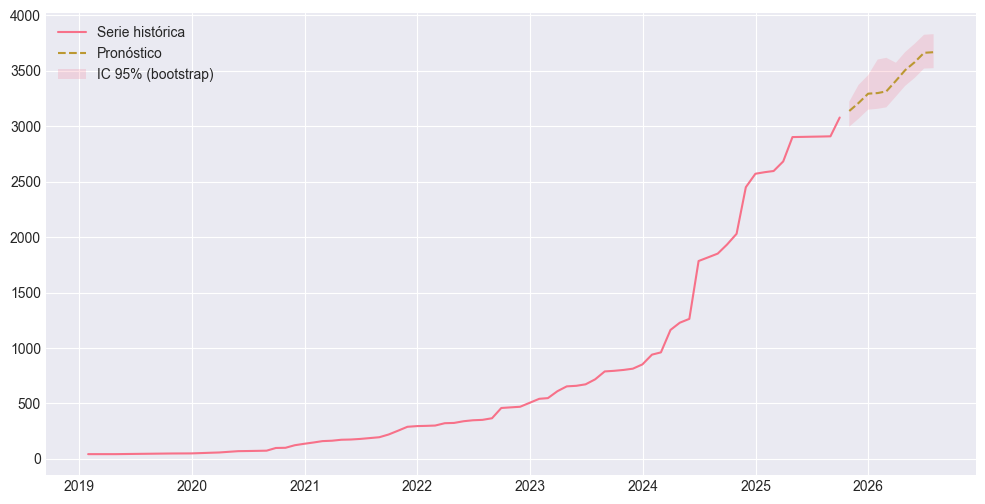

In [79]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(serie, label="Serie histórica")
plt.plot(forecast_10_rec_exp, label="Pronóstico", linestyle="--")
plt.fill_between(
    forecast_10_rec_exp.index,
    lower_95_boot,
    upper_95_boot,
    alpha=0.2,
    label="IC 95% (bootstrap)",
)
plt.legend()
plt.grid(True)
plt.show()


## **Función Entrenamiento ventana movil y busqueda de mejores add, trend, seasonal, y sus respectivos Alpha, Beta y Gamma**

In [80]:
warnings.filterwarnings("ignore")
# definimos la funcion de optimizacion con los hiper paramatros. damped hace referencia a la amortiguacion de la tendencia 
def rmse_vec(a, b):
    return np.sqrt(np.mean((a - b)**2))

def moving_window_hw_rmse(serie,
                          horizon,
                          window_size,
                          trend,
                          seasonal,
                          seasonal_periods,
                          alpha,
                          beta,
                          gamma,
                          damped):

    y = np.asarray(serie.dropna())
    n = len(y)

    errors = []

    # Posiciones finales posibles de la ventana
    for start in range(0, n - window_size - horizon + 1):
        
        train = y[start : start + window_size]
        test  = y[start + window_size : start + window_size + horizon]

        try:
            model = ExponentialSmoothing(
                train,
                trend=trend,
                seasonal=seasonal,
                seasonal_periods=seasonal_periods,
                damped_trend=damped,
                initialization_method="estimated",
            )

            fit = model.fit(
                optimized=True,
                smoothing_level=alpha,
                smoothing_slope=beta if trend else None,
                smoothing_seasonal=gamma if seasonal else None
            )

            pred = fit.forecast(horizon)

            error = rmse_vec(pred, test)

            if not math.isfinite(error):
                return float("inf")

            errors.append(error)

        except Exception:
            return float("inf")

    if len(errors) == 0:
        return float("inf")

    return float(np.mean(errors))


## **Optimización Bayesiana**

In [81]:
H = 10

def objective(trial):

    # MODELOS
    trend = trial.suggest_categorical("trend", [None, "add", "mul"])
    seasonal = trial.suggest_categorical("seasonal", [None, "add", "mul"])

    seasonal_periods = None
    if seasonal is not None:
        seasonal_periods = trial.suggest_categorical("seasonal_periods", [6, 12])

    damped = trial.suggest_categorical("damped", [False, True])

    # α β γ
    alpha = trial.suggest_float("alpha", 0.01, 0.99)
    beta  = trial.suggest_float("beta", 0.01, 0.99) if trend else None
    gamma = trial.suggest_float("gamma", 0.01, 0.99) if seasonal else None

    # Tamaño ventana móvil (36–82 meses)
    window_size = trial.suggest_int("window_size", 36, 82)
    #window_size = 80

    rmse = moving_window_hw_rmse(
        serie,
        horizon=H,
        window_size=window_size,
        trend=trend,
        seasonal=seasonal,
        seasonal_periods=seasonal_periods,
        alpha=alpha,
        beta=beta,
        gamma=gamma,
        damped=damped,
    )

    return rmse


In [82]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=60, n_jobs=1)
rmse_hw_movil=study.best_value
print("Mejor RMSE:", study.best_value)
print("Mejores parámetros:", study.best_params)



[I 2025-11-27 14:47:47,156] A new study created in memory with name: no-name-7b3f45c6-afd6-465a-be93-9ca30a1b4b29
[I 2025-11-27 14:47:47,306] Trial 0 finished with value: 754.4396096377191 and parameters: {'trend': 'add', 'seasonal': 'mul', 'seasonal_periods': 12, 'damped': False, 'alpha': 0.9093890009808128, 'beta': 0.3447902336092917, 'gamma': 0.6424543236479872, 'window_size': 70}. Best is trial 0 with value: 754.4396096377191.
[I 2025-11-27 14:47:47,307] Trial 1 finished with value: inf and parameters: {'trend': None, 'seasonal': 'add', 'seasonal_periods': 12, 'damped': False, 'alpha': 0.826315729193504, 'gamma': 0.8695402275418012, 'window_size': 75}. Best is trial 0 with value: 754.4396096377191.
[I 2025-11-27 14:47:47,622] Trial 2 finished with value: 850.926621983258 and parameters: {'trend': 'mul', 'seasonal': 'add', 'seasonal_periods': 6, 'damped': False, 'alpha': 0.3041707612108743, 'beta': 0.815079675635399, 'gamma': 0.7358674325518407, 'window_size': 63}. Best is trial 0 w

Mejor RMSE: 251.9447126699658
Mejores parámetros: {'trend': 'add', 'seasonal': 'add', 'seasonal_periods': 6, 'damped': False, 'alpha': 0.6356724975170732, 'beta': 0.3659780989464472, 'gamma': 0.6876034619318072, 'window_size': 38}


## **Implementacion del modelo y pronostico de los 10 periodos**

In [83]:
best = study.best_params

trend   = best["trend"]
seasonal = best["seasonal"]
seasonal_periods = best.get("seasonal_periods", None)
damped = best["damped"]
alpha  = best["alpha"]
beta   = best.get("beta", None)
gamma  = best.get("gamma", None)

model = ExponentialSmoothing(
    serie,
    trend=trend,
    seasonal=seasonal,
    seasonal_periods=seasonal_periods,
    damped_trend=damped,
    initialization_method="estimated",
)

fit = model.fit(
    optimized=False,
    smoothing_level=alpha,
    smoothing_slope=beta if trend else None,
    smoothing_seasonal=gamma if seasonal else None,
)

forecast_10_mvoil_exp = fit.forecast(10)
forecast_10_mvoil_exp


2025-10-31    3267.575265
2025-11-30    3359.436765
2025-12-31    3534.680543
2026-01-31    3613.401812
2026-02-28    3638.097339
2026-03-31    3642.635123
2026-04-30    3890.435382
2026-05-31    3982.296882
2026-06-30    4157.540660
2026-07-31    4236.261930
Freq: ME, dtype: float64

In [84]:
# llamamos a la funcion para generar los intervalos de confianza
H = 10  # horizonte de 12 pasos (por ejemplo, 12 meses)

forecast_10_mvoil_exp, lower_95_boot, upper_95_boot = bootstrap_hw_pi(
    fit,
    H=H,
    n_sim=1000,
    alpha=0.05,       # 95% de confianza
    random_state=42   # opcional, para reproducibilidad
)

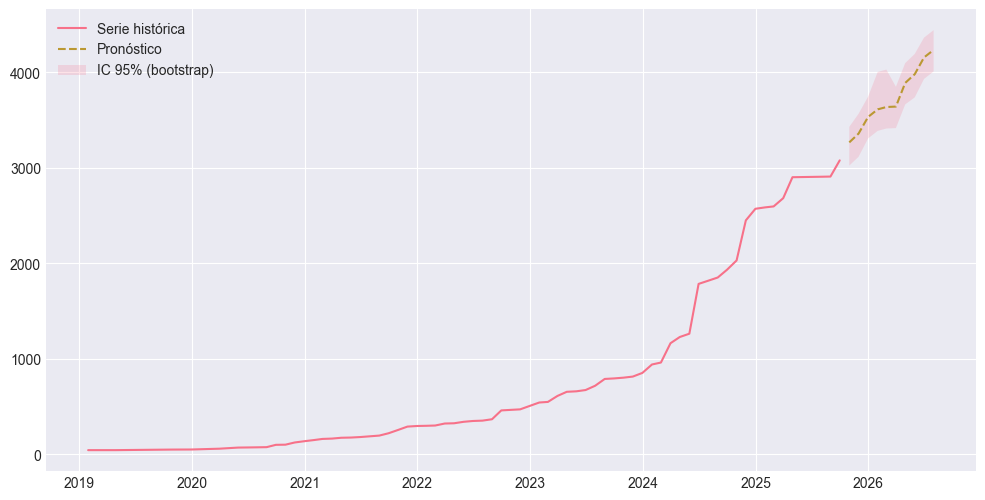

In [85]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(serie, label="Serie histórica")
plt.plot(forecast_10_mvoil_exp, label="Pronóstico", linestyle="--")
plt.fill_between(
    forecast_10_mvoil_exp.index,
    lower_95_boot,
    upper_95_boot,
    alpha=0.2,
    label="IC 95% (bootstrap)",
)
plt.legend()
plt.grid(True)
plt.show()

## **Implementacion del modelo PROPHET con ventana recursiva**

In [32]:
solar = df.copy().reset_index()     # recuperamos la columna Fecha desde el índice
solar = solar.rename(columns={"Fecha": "ds", "SOLAR": "y"}) # se cambia el nombre ya que es necesario para utilizar el modelo 
solar = solar[["ds", "y"]]          # solo Prophet columns
solar["ds"] = pd.to_datetime(solar["ds"]) # se convierte en una serie de tiempo
solar = solar.sort_values("ds") #se ordena la columna 
solar.tail()

,ds,y
76,2025-05-31,2904.185550
77,2025-06-30,2905.793884
78,2025-07-31,2907.402217
79,2025-08-31,2909.382217
80,2025-09-30,3079.000000


In [33]:
import numpy as np
from sklearn.metrics import mean_squared_error
from prophet import Prophet  

def rmse_expanding_prophet(
    df,                     # dataframe de entrada
    horizon=10,             # Número de pasos hacia adelante que quieres predecir en cada iteración.
    initial_window=24,   # Tamaño inicial del conjunto de entrenamiento.
    step_size=1,            #Controla cuántos pasos avanzas en el tiempo entre una ventana de validación y la siguiente.
    changepoint_prior_scale=0.05,   #Controla cuánta flexibilidad tiene el modelo para cambiar la tendencia (los “changepoints”). valor razonable por defecto
    seasonality_prior_scale=10.0,  #Controla la flexibilidad de la estacionalidad (por ejemplo, patrones anuales, mensuales).
    seasonality_mode="additive",    #Define cómo se combina la estacionalidad con la tendencia y el nivel:  y(t)=tendencia(t)+estacionalidad(t)+error
):
    """
    Valida un modelo Prophet para df (columnas ds, y) con
    ventana expandida y devuelve RMSE medio.
    """

    df = df.dropna().copy()     #Elimina cualquier fila que contenga valores NaN (vacíos o faltante
    n = len(df)                 #Guarda en n el número total de filas del DataFrame.
    rmses = []                  #Crea una lista vacía donde guardarás todos los valores de RMSE generados en cada ventana de validación.

    # índices donde termina el conjunto de entrenamiento
    for end_train in range(initial_window, n - horizon + 1, step_size): #genera una secuencia de índices end_train:
        train = df.iloc[:end_train]         #selecciona todas las filas desde el inicio hasta el índice
        test  = df.iloc[end_train:end_train + horizon] #Define el conjunto de prueba (test) para esa iteración.Empieza justo donde termina el train, en end_train.

        if len(test) < horizon:    #erifica que el conjunto de prueba tenga realmente el tamaño del horizonte.
            continue

        try:
            m = Prophet(                #se crea el modelo prophety todos sus hiperparametros
                changepoint_prior_scale=changepoint_prior_scale, #Controla la flexibilidad de la tendencia.
                seasonality_prior_scale=seasonality_prior_scale, #Controla cuánta flexibilidad tiene la estacionalidad para ajustarse a los datos.
                seasonality_mode=seasonality_mode, #cómo se combina la estacionalidad con la tendencia.
                yearly_seasonality=True,    #Activa estacionalidad anual (útil si tus datos son mensuales y hay patrones por año)
                weekly_seasonality=False,   #Desactiva estacionalidad semanal (no son relevantes si tus datos son mensuales).
                daily_seasonality=False,    #Desactivas estacionalidad diaria (no son relevantes si tus datos son mensuales).
            )

            # Puedes añadir más estacionalidades si lo necesitas:
            # m.add_seasonality(name="mensual", period=12, fourier_order=5)

            m.fit(train)                    #Ajusta  el modelo Prophet usando el conjunto de entrenamiento train.

            future = m.make_future_dataframe(periods=horizon, freq="M") #Crea un DataFrame con todas las fechas futuras que quieres predecir.
            forecast = m.predict(future)        #Genera la predicción completa de Prophet para:las fechas históricas (in-sample) y las fechas futuras (out-of-sample)

            # Tomamos solo los últimos 'horizon' pronósticos
            y_pred = forecast["yhat"].iloc[-horizon:].values    #Selecciona las últimas horizon filas de la columna yhat. Es decir, únicamente las predicciones futuras, NO las históricas.
            y_true = test["y"].values                       #Extrae del conjunto de prueba (test) los valores reales de la serie.

            rmse_fold = np.sqrt(mean_squared_error(y_true, y_pred)) #guarda el rmse en una ventana
            rmses.append(rmse_fold)

        except Exception:
            # si algo explota, penalizamos
            return np.inf

    if not rmses:
        return np.inf

    return float(np.mean(rmses))


In [34]:
import optuna

def objective(trial):
    # Espacio de búsqueda de hiperparámetros
    changepoint_prior_scale = trial.suggest_float("changepoint_prior_scale", 0.001, 0.5, log=True) #Controla cuánta flexibilidad tiene la tendencia para cambiar.
    seasonality_prior_scale = trial.suggest_float("seasonality_prior_scale", 1.0, 40.0, log=True) #Controla la flexibilidad de la estacionalidad.
    seasonality_mode = trial.suggest_categorical("seasonality_mode", ["additive", "multiplicative"]) # busca si es modo aditivo o multiplicativo

    rmse = rmse_expanding_prophet(              #entrena varios modelos Prophet usando ventana expandida,
        df=solar,                           
        horizon=10,                 #En cada iteración, predice 12 pasos hacia adelante     
        initial_window=24,           #“La primera vez, entrena el modelo con 24 filas (por ejemplo meses)”
        step_size=1,                #Esto define cuánto avanza la ventana en cada iteración.
        changepoint_prior_scale=changepoint_prior_scale,
        seasonality_prior_scale=seasonality_prior_scale,
        seasonality_mode=seasonality_mode,
    )

    return rmse

study = optuna.create_study(direction="minimize") #crea un objeto "Study", que es donde Optuna guarda:los resultados de cada prueba,, los mejores hiperparámetros encontrados,, rmse
study.optimize(objective, n_trials=30)   # puedes subir n_trials si tienes tiempo
rmse_pro_rec=study.best_value
print("Mejor RMSE:", study.best_value)
print("Mejores hiperparámetros:", study.best_params)


[I 2025-11-27 08:58:28,885] A new study created in memory with name: no-name-65decf3c-9cb5-49a0-8a56-6aad86bb13f8
08:58:29 - cmdstanpy - INFO - Chain [1] start processing
08:58:29 - cmdstanpy - INFO - Chain [1] done processing
08:58:29 - cmdstanpy - INFO - Chain [1] start processing
08:58:29 - cmdstanpy - INFO - Chain [1] done processing
08:58:29 - cmdstanpy - INFO - Chain [1] start processing
08:58:29 - cmdstanpy - INFO - Chain [1] done processing
08:58:29 - cmdstanpy - INFO - Chain [1] start processing
08:58:29 - cmdstanpy - INFO - Chain [1] done processing
08:58:30 - cmdstanpy - INFO - Chain [1] start processing
08:58:30 - cmdstanpy - INFO - Chain [1] done processing
08:58:30 - cmdstanpy - INFO - Chain [1] start processing
08:58:30 - cmdstanpy - INFO - Chain [1] done processing
08:58:30 - cmdstanpy - INFO - Chain [1] start processing
08:58:30 - cmdstanpy - INFO - Chain [1] done processing
08:58:30 - cmdstanpy - INFO - Chain [1] start processing
08:58:30 - cmdstanpy - INFO - Chain [1

Mejor RMSE: 227.48198265808637
Mejores hiperparámetros: {'changepoint_prior_scale': 0.49315680795896527, 'seasonality_prior_scale': 1.652528542981689, 'seasonality_mode': 'additive'}


In [ ]:
best_params = study.best_params

m_final = Prophet(
    changepoint_prior_scale=best_params["changepoint_prior_scale"],
    seasonality_prior_scale=best_params["seasonality_prior_scale"],
    seasonality_mode=best_params["seasonality_mode"],
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
)

# de nuevo, puedes añadir estacionalidad mensual explícita si lo deseas:
# m_final.add_seasonality(name="mensual", period=10, fourier_order=5)

m_final.fit(solar)

# Pronóstico de los próximos 10 meses
future = m_final.make_future_dataframe(periods=10, freq="M")
forecast = m_final.predict(future)

# Extraemos solo los 10 periodos futuros
forecast_10_rec = forecast.tail(10)[["ds", "yhat", "yhat_lower", "yhat_upper"]]
forecast_10_rec


10:39:30 - cmdstanpy - INFO - Chain [1] start processing
10:39:31 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
81,2025-10-31,3397.453546,3302.888849,3503.202482
82,2025-11-30,3585.447342,3489.212928,3674.293313
83,2025-12-31,3699.300918,3600.850277,3795.315288
84,2026-01-31,3790.540644,3689.872226,3884.973527
85,2026-02-28,3869.519025,3769.081352,3980.719653
86,2026-03-31,3982.417818,3882.407250,4093.290130
87,2026-04-30,4094.538164,3986.736479,4201.233371
88,2026-05-31,4178.973578,4061.462465,4295.996787
89,2026-06-30,4294.123950,4166.131290,4425.136973
90,2026-07-31,4393.804356,4252.866070,4525.151439


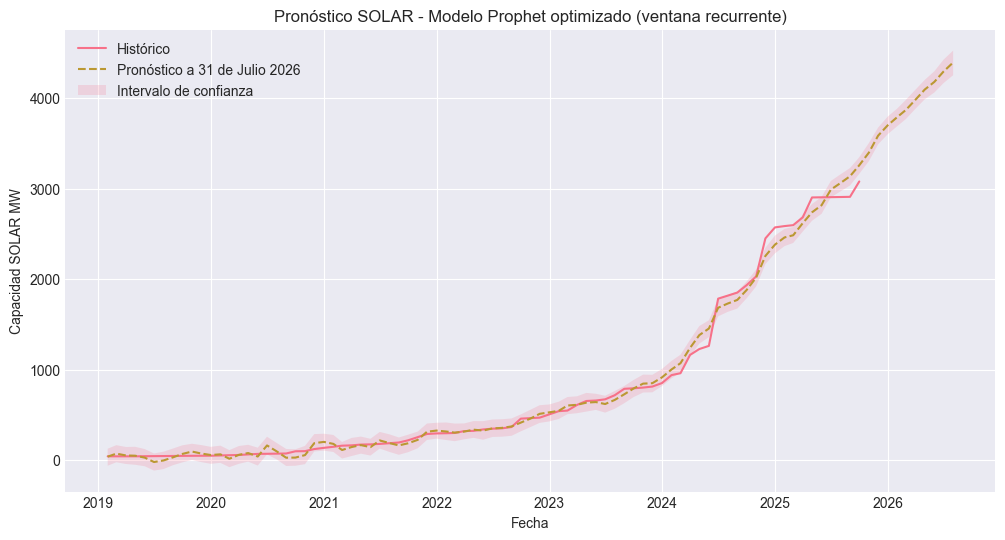

In [55]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(solar["ds"], solar["y"], label="Histórico")
plt.title("Pronóstico SOLAR - Modelo Prophet optimizado (ventana recurrente)")
plt.xlabel("Fecha")
plt.ylabel("Capacidad SOLAR MW")

ax.plot(forecast["ds"], forecast["yhat"], label="Pronóstico a 31 de Julio 2026", linestyle="--")
ax.fill_between(
    forecast["ds"],
    forecast["yhat_lower"],
    forecast["yhat_upper"],
    alpha=0.2,
    label="Intervalo de confianza",
)

ax.legend()
ax.grid(True)
plt.show()

## **Implementacion del modelo PROPHET con ventana movil**

In [56]:
def rmse_rolling_prophet(
    df,
    horizon=10,
    window_size=36,     # tamaño fijo de ventana
    step_size=1,
    changepoint_prior_scale=0.05,
    seasonality_prior_scale=10.0,
    seasonality_mode="additive",
):
    """
    Validación con ventana móvil (rolling window) para Prophet.
   
    """

    df = df.dropna().copy()
    n = len(df)
    rmses = []

    for start in range(0, n - window_size - horizon + 1, step_size):

        end_train = start + window_size
        train = df.iloc[start:end_train]
        test  = df.iloc[end_train:end_train + horizon]

        if len(test) < horizon:
            continue

        try:
            m = Prophet(
                changepoint_prior_scale=changepoint_prior_scale,
                seasonality_prior_scale=seasonality_prior_scale,
                seasonality_mode=seasonality_mode,
                yearly_seasonality=True,
                weekly_seasonality=False,
                daily_seasonality=False,
            )

            # Ejemplo: estacionalidad mensual adicional
            # m.add_seasonality(name="mensual", period=12, fourier_order=5)

            m.fit(train)

            future = m.make_future_dataframe(periods=horizon, freq="M")
            forecast = m.predict(future)

            y_pred = forecast["yhat"].iloc[-horizon:].values
            y_true = test["y"].values

            rmse_fold = np.sqrt(mean_squared_error(y_true, y_pred))
            rmses.append(rmse_fold)

        except Exception:
            return np.inf

    if not rmses:
        return np.inf

    return float(np.mean(rmses))


In [57]:
from optuna.samplers import TPESampler

H = 10          # horizonte de pronóstico
WINDOW = 36     # tamaño de ventana fija (36 meses ~ 3 años)

def objective(trial):
    # Hiperparámetros de Prophet a optimizar
    changepoint_prior_scale = trial.suggest_float(
        "changepoint_prior_scale", 0.001, 0.5, log=True
    )
    seasonality_prior_scale = trial.suggest_float(
        "seasonality_prior_scale", 0.1, 20.0, log=True
    )
    seasonality_mode = trial.suggest_categorical(
        "seasonality_mode", ["additive", "multiplicative"]
    )

    # Si quieres, podrías optimizar también horizon/window_size,
    # pero es mejor mantenerlos fijos para comparar.

    rmse = rmse_rolling_prophet(
        df=solar,                    # tu DataFrame con columnas ds, y
        horizon=H,
        window_size=WINDOW,
        step_size=1,
        changepoint_prior_scale=changepoint_prior_scale,
        seasonality_prior_scale=seasonality_prior_scale,
        seasonality_mode=seasonality_mode,
    )

    return rmse


In [58]:
sampler = TPESampler(seed=42)  # para reproducibilidad
study = optuna.create_study(direction="minimize", sampler=sampler)

study.optimize(objective, n_trials=30, show_progress_bar=True)
rmse_pro_movil=study.best_value
print("Mejor RMSE:", study.best_value)
print("Mejores parámetros:", study.best_params)

[I 2025-11-27 10:54:58,114] A new study created in memory with name: no-name-719df506-df3f-48ae-8239-0f00359e1e59
  0%|          | 0/30 [00:00<?, ?it/s]10:54:58 - cmdstanpy - INFO - Chain [1] start processing
10:54:58 - cmdstanpy - INFO - Chain [1] done processing
10:54:58 - cmdstanpy - INFO - Chain [1] start processing
10:54:58 - cmdstanpy - INFO - Chain [1] done processing
10:54:58 - cmdstanpy - INFO - Chain [1] start processing
10:54:58 - cmdstanpy - INFO - Chain [1] done processing
10:54:58 - cmdstanpy - INFO - Chain [1] start processing
10:54:59 - cmdstanpy - INFO - Chain [1] done processing
10:54:59 - cmdstanpy - INFO - Chain [1] start processing
10:54:59 - cmdstanpy - INFO - Chain [1] done processing
10:54:59 - cmdstanpy - INFO - Chain [1] start processing
10:54:59 - cmdstanpy - INFO - Chain [1] done processing
10:54:59 - cmdstanpy - INFO - Chain [1] start processing
10:54:59 - cmdstanpy - INFO - Chain [1] done processing
10:54:59 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-11-27 10:55:07,253] Trial 0 finished with value: 477.84611968493596 and parameters: {'changepoint_prior_scale': 0.010253509690168494, 'seasonality_prior_scale': 15.40359659501924, 'seasonality_mode': 'additive'}. Best is trial 0 with value: 477.84611968493596.


10:55:07 - cmdstanpy - INFO - Chain [1] start processing
10:55:07 - cmdstanpy - INFO - Chain [1] done processing
10:55:07 - cmdstanpy - INFO - Chain [1] start processing
10:55:07 - cmdstanpy - INFO - Chain [1] done processing
10:55:07 - cmdstanpy - INFO - Chain [1] start processing
10:55:08 - cmdstanpy - INFO - Chain [1] done processing
10:55:08 - cmdstanpy - INFO - Chain [1] start processing
10:55:08 - cmdstanpy - INFO - Chain [1] done processing
10:55:08 - cmdstanpy - INFO - Chain [1] start processing
10:55:08 - cmdstanpy - INFO - Chain [1] done processing
10:55:08 - cmdstanpy - INFO - Chain [1] start processing
10:55:08 - cmdstanpy - INFO - Chain [1] done processing
10:55:08 - cmdstanpy - INFO - Chain [1] start processing
10:55:08 - cmdstanpy - INFO - Chain [1] done processing
10:55:08 - cmdstanpy - INFO - Chain [1] start processing
10:55:09 - cmdstanpy - INFO - Chain [1] done processing
10:55:09 - cmdstanpy - INFO - Chain [1] start processing
10:55:09 - cmdstanpy - INFO - Chain [1]

[I 2025-11-27 10:55:15,399] Trial 1 finished with value: 488.8909313111226 and parameters: {'changepoint_prior_scale': 0.0026368755339723046, 'seasonality_prior_scale': 0.22853255256339208, 'seasonality_mode': 'multiplicative'}. Best is trial 0 with value: 477.84611968493596.


10:55:15 - cmdstanpy - INFO - Chain [1] done processing
10:55:15 - cmdstanpy - INFO - Chain [1] start processing
10:55:16 - cmdstanpy - INFO - Chain [1] done processing
10:55:16 - cmdstanpy - INFO - Chain [1] start processing
10:55:16 - cmdstanpy - INFO - Chain [1] done processing
10:55:16 - cmdstanpy - INFO - Chain [1] start processing
10:55:16 - cmdstanpy - INFO - Chain [1] done processing
10:55:16 - cmdstanpy - INFO - Chain [1] start processing
10:55:17 - cmdstanpy - INFO - Chain [1] done processing
10:55:17 - cmdstanpy - INFO - Chain [1] start processing
10:55:17 - cmdstanpy - INFO - Chain [1] done processing
10:55:17 - cmdstanpy - INFO - Chain [1] start processing
10:55:17 - cmdstanpy - INFO - Chain [1] done processing
10:55:17 - cmdstanpy - INFO - Chain [1] start processing
10:55:18 - cmdstanpy - INFO - Chain [1] done processing
10:55:18 - cmdstanpy - INFO - Chain [1] start processing
10:55:18 - cmdstanpy - INFO - Chain [1] done processing
10:55:18 - cmdstanpy - INFO - Chain [1] 

[I 2025-11-27 10:55:27,612] Trial 2 finished with value: 324.7397204632166 and parameters: {'changepoint_prior_scale': 0.041917115166952006, 'seasonality_prior_scale': 4.258888210290081, 'seasonality_mode': 'multiplicative'}. Best is trial 2 with value: 324.7397204632166.


10:55:28 - cmdstanpy - INFO - Chain [1] done processing
10:55:28 - cmdstanpy - INFO - Chain [1] start processing
10:55:28 - cmdstanpy - INFO - Chain [1] done processing
10:55:28 - cmdstanpy - INFO - Chain [1] start processing
10:55:43 - cmdstanpy - INFO - Chain [1] done processing
10:55:44 - cmdstanpy - INFO - Chain [1] start processing
10:55:45 - cmdstanpy - INFO - Chain [1] done processing
10:55:45 - cmdstanpy - INFO - Chain [1] start processing
10:56:33 - cmdstanpy - INFO - Chain [1] done processing
10:56:34 - cmdstanpy - INFO - Chain [1] start processing
10:57:22 - cmdstanpy - INFO - Chain [1] done processing
10:57:22 - cmdstanpy - INFO - Chain [1] start processing
10:58:10 - cmdstanpy - INFO - Chain [1] done processing
10:58:10 - cmdstanpy - INFO - Chain [1] start processing
10:58:58 - cmdstanpy - INFO - Chain [1] done processing
10:58:58 - cmdstanpy - INFO - Chain [1] start processing
10:59:43 - cmdstanpy - INFO - Chain [1] done processing
10:59:43 - cmdstanpy - INFO - Chain [1] 

[I 2025-11-27 11:13:01,181] Trial 3 finished with value: 300.40806345837734 and parameters: {'changepoint_prior_scale': 0.1764971584817571, 'seasonality_prior_scale': 0.30803400529839686, 'seasonality_mode': 'multiplicative'}. Best is trial 3 with value: 300.40806345837734.


11:13:01 - cmdstanpy - INFO - Chain [1] done processing
11:13:01 - cmdstanpy - INFO - Chain [1] start processing
11:13:02 - cmdstanpy - INFO - Chain [1] done processing
11:13:02 - cmdstanpy - INFO - Chain [1] start processing
11:13:02 - cmdstanpy - INFO - Chain [1] done processing
11:13:02 - cmdstanpy - INFO - Chain [1] start processing
11:13:02 - cmdstanpy - INFO - Chain [1] done processing
11:13:03 - cmdstanpy - INFO - Chain [1] start processing
11:13:03 - cmdstanpy - INFO - Chain [1] done processing
11:13:03 - cmdstanpy - INFO - Chain [1] start processing
11:13:03 - cmdstanpy - INFO - Chain [1] done processing
11:13:04 - cmdstanpy - INFO - Chain [1] start processing
11:13:04 - cmdstanpy - INFO - Chain [1] done processing
11:13:04 - cmdstanpy - INFO - Chain [1] start processing
11:13:04 - cmdstanpy - INFO - Chain [1] done processing
11:13:04 - cmdstanpy - INFO - Chain [1] start processing
11:13:05 - cmdstanpy - INFO - Chain [1] done processing
11:13:05 - cmdstanpy - INFO - Chain [1] 

[I 2025-11-27 11:13:17,804] Trial 4 finished with value: 477.43210438038346 and parameters: {'changepoint_prior_scale': 0.006624310605949983, 'seasonality_prior_scale': 1.6124278458562613, 'seasonality_mode': 'additive'}. Best is trial 3 with value: 300.40806345837734.


11:13:18 - cmdstanpy - INFO - Chain [1] done processing
11:13:19 - cmdstanpy - INFO - Chain [1] start processing
11:13:19 - cmdstanpy - INFO - Chain [1] done processing
11:13:19 - cmdstanpy - INFO - Chain [1] start processing
11:13:20 - cmdstanpy - INFO - Chain [1] done processing
11:13:20 - cmdstanpy - INFO - Chain [1] start processing
11:13:21 - cmdstanpy - INFO - Chain [1] done processing
11:13:21 - cmdstanpy - INFO - Chain [1] start processing
11:13:21 - cmdstanpy - INFO - Chain [1] done processing
11:13:21 - cmdstanpy - INFO - Chain [1] start processing
11:13:22 - cmdstanpy - INFO - Chain [1] done processing
11:13:22 - cmdstanpy - INFO - Chain [1] start processing
11:13:22 - cmdstanpy - INFO - Chain [1] done processing
11:13:23 - cmdstanpy - INFO - Chain [1] start processing
11:13:23 - cmdstanpy - INFO - Chain [1] done processing
11:13:24 - cmdstanpy - INFO - Chain [1] start processing
11:13:24 - cmdstanpy - INFO - Chain [1] done processing
11:13:24 - cmdstanpy - INFO - Chain [1] 

[I 2025-11-27 11:13:44,527] Trial 5 finished with value: 308.4783714453492 and parameters: {'changepoint_prior_scale': 0.044809759182149515, 'seasonality_prior_scale': 0.20940138873937433, 'seasonality_mode': 'multiplicative'}. Best is trial 3 with value: 300.40806345837734.


11:13:44 - cmdstanpy - INFO - Chain [1] done processing
11:13:45 - cmdstanpy - INFO - Chain [1] start processing
11:13:45 - cmdstanpy - INFO - Chain [1] done processing
11:13:45 - cmdstanpy - INFO - Chain [1] start processing
11:13:46 - cmdstanpy - INFO - Chain [1] done processing
11:13:46 - cmdstanpy - INFO - Chain [1] start processing
11:13:46 - cmdstanpy - INFO - Chain [1] done processing
11:13:46 - cmdstanpy - INFO - Chain [1] start processing
11:13:47 - cmdstanpy - INFO - Chain [1] done processing
11:13:47 - cmdstanpy - INFO - Chain [1] start processing
11:13:47 - cmdstanpy - INFO - Chain [1] done processing
11:13:47 - cmdstanpy - INFO - Chain [1] start processing
11:13:48 - cmdstanpy - INFO - Chain [1] done processing
11:13:48 - cmdstanpy - INFO - Chain [1] start processing
11:13:49 - cmdstanpy - INFO - Chain [1] done processing
11:13:49 - cmdstanpy - INFO - Chain [1] start processing
11:13:49 - cmdstanpy - INFO - Chain [1] done processing
11:13:49 - cmdstanpy - INFO - Chain [1] 

[I 2025-11-27 11:14:07,700] Trial 6 finished with value: 525.9225305039375 and parameters: {'changepoint_prior_scale': 0.01701841881702917, 'seasonality_prior_scale': 6.407866261851015, 'seasonality_mode': 'multiplicative'}. Best is trial 3 with value: 300.40806345837734.


11:14:08 - cmdstanpy - INFO - Chain [1] done processing
11:14:08 - cmdstanpy - INFO - Chain [1] start processing
11:14:08 - cmdstanpy - INFO - Chain [1] done processing
11:14:08 - cmdstanpy - INFO - Chain [1] start processing
11:14:09 - cmdstanpy - INFO - Chain [1] done processing
11:14:09 - cmdstanpy - INFO - Chain [1] start processing
11:14:09 - cmdstanpy - INFO - Chain [1] done processing
11:14:09 - cmdstanpy - INFO - Chain [1] start processing
11:14:10 - cmdstanpy - INFO - Chain [1] done processing
11:14:10 - cmdstanpy - INFO - Chain [1] start processing
11:14:10 - cmdstanpy - INFO - Chain [1] done processing
11:14:11 - cmdstanpy - INFO - Chain [1] start processing
11:14:11 - cmdstanpy - INFO - Chain [1] done processing
11:14:11 - cmdstanpy - INFO - Chain [1] start processing
11:14:12 - cmdstanpy - INFO - Chain [1] done processing
11:14:12 - cmdstanpy - INFO - Chain [1] start processing
11:14:12 - cmdstanpy - INFO - Chain [1] done processing
11:14:13 - cmdstanpy - INFO - Chain [1] 

[I 2025-11-27 11:14:30,678] Trial 7 finished with value: 392.55420692609016 and parameters: {'changepoint_prior_scale': 0.039710847107924725, 'seasonality_prior_scale': 0.12790390175145838, 'seasonality_mode': 'additive'}. Best is trial 3 with value: 300.40806345837734.


11:14:31 - cmdstanpy - INFO - Chain [1] done processing
11:14:31 - cmdstanpy - INFO - Chain [1] start processing
11:14:32 - cmdstanpy - INFO - Chain [1] done processing
11:14:32 - cmdstanpy - INFO - Chain [1] start processing
11:14:32 - cmdstanpy - INFO - Chain [1] done processing
11:14:32 - cmdstanpy - INFO - Chain [1] start processing
11:14:33 - cmdstanpy - INFO - Chain [1] done processing
11:14:33 - cmdstanpy - INFO - Chain [1] start processing
11:14:34 - cmdstanpy - INFO - Chain [1] done processing
11:14:34 - cmdstanpy - INFO - Chain [1] start processing
11:14:34 - cmdstanpy - INFO - Chain [1] done processing
11:14:34 - cmdstanpy - INFO - Chain [1] start processing
11:14:35 - cmdstanpy - INFO - Chain [1] done processing
11:14:35 - cmdstanpy - INFO - Chain [1] start processing
11:14:36 - cmdstanpy - INFO - Chain [1] done processing
11:14:36 - cmdstanpy - INFO - Chain [1] start processing
11:14:36 - cmdstanpy - INFO - Chain [1] done processing
11:14:36 - cmdstanpy - INFO - Chain [1] 

[I 2025-11-27 11:14:53,850] Trial 8 finished with value: 477.35678903249834 and parameters: {'changepoint_prior_scale': 0.0014982086432155466, 'seasonality_prior_scale': 15.255065745117381, 'seasonality_mode': 'additive'}. Best is trial 3 with value: 300.40806345837734.


11:14:54 - cmdstanpy - INFO - Chain [1] done processing
11:14:54 - cmdstanpy - INFO - Chain [1] start processing
11:14:54 - cmdstanpy - INFO - Chain [1] done processing
11:14:54 - cmdstanpy - INFO - Chain [1] start processing
11:14:55 - cmdstanpy - INFO - Chain [1] done processing
11:14:55 - cmdstanpy - INFO - Chain [1] start processing
11:14:55 - cmdstanpy - INFO - Chain [1] done processing
11:14:55 - cmdstanpy - INFO - Chain [1] start processing
11:14:55 - cmdstanpy - INFO - Chain [1] done processing
11:14:56 - cmdstanpy - INFO - Chain [1] start processing
11:14:56 - cmdstanpy - INFO - Chain [1] done processing
11:14:56 - cmdstanpy - INFO - Chain [1] start processing
11:14:56 - cmdstanpy - INFO - Chain [1] done processing
11:14:57 - cmdstanpy - INFO - Chain [1] start processing
11:14:57 - cmdstanpy - INFO - Chain [1] done processing
11:14:57 - cmdstanpy - INFO - Chain [1] start processing
11:14:57 - cmdstanpy - INFO - Chain [1] done processing
11:14:57 - cmdstanpy - INFO - Chain [1] 

[I 2025-11-27 11:15:11,336] Trial 9 finished with value: 471.23272336402414 and parameters: {'changepoint_prior_scale': 0.00663962307985946, 'seasonality_prior_scale': 0.1677824238407793, 'seasonality_mode': 'additive'}. Best is trial 3 with value: 300.40806345837734.


11:15:48 - cmdstanpy - INFO - Chain [1] done processing
11:15:48 - cmdstanpy - INFO - Chain [1] start processing
11:16:25 - cmdstanpy - INFO - Chain [1] done processing
11:16:25 - cmdstanpy - INFO - Chain [1] start processing
11:17:01 - cmdstanpy - INFO - Chain [1] done processing
11:17:02 - cmdstanpy - INFO - Chain [1] start processing
11:17:38 - cmdstanpy - INFO - Chain [1] done processing
11:17:38 - cmdstanpy - INFO - Chain [1] start processing
11:18:16 - cmdstanpy - INFO - Chain [1] done processing
11:18:16 - cmdstanpy - INFO - Chain [1] start processing
11:18:53 - cmdstanpy - INFO - Chain [1] done processing
11:18:53 - cmdstanpy - INFO - Chain [1] start processing
11:19:31 - cmdstanpy - INFO - Chain [1] done processing
11:19:31 - cmdstanpy - INFO - Chain [1] start processing
11:20:08 - cmdstanpy - INFO - Chain [1] done processing
11:20:08 - cmdstanpy - INFO - Chain [1] start processing
11:20:46 - cmdstanpy - INFO - Chain [1] done processing
11:20:47 - cmdstanpy - INFO - Chain [1] 

[I 2025-11-27 11:36:42,282] Trial 10 finished with value: 301.513332139821 and parameters: {'changepoint_prior_scale': 0.3555454971866563, 'seasonality_prior_scale': 0.6869866335896525, 'seasonality_mode': 'multiplicative'}. Best is trial 3 with value: 300.40806345837734.


11:37:18 - cmdstanpy - INFO - Chain [1] done processing
11:37:19 - cmdstanpy - INFO - Chain [1] start processing
11:37:50 - cmdstanpy - INFO - Chain [1] done processing
11:37:50 - cmdstanpy - INFO - Chain [1] start processing
11:38:05 - cmdstanpy - INFO - Chain [1] done processing
11:38:05 - cmdstanpy - INFO - Chain [1] start processing
11:38:32 - cmdstanpy - INFO - Chain [1] done processing
11:38:32 - cmdstanpy - INFO - Chain [1] start processing
11:39:11 - cmdstanpy - INFO - Chain [1] done processing
11:39:11 - cmdstanpy - INFO - Chain [1] start processing
11:39:52 - cmdstanpy - INFO - Chain [1] done processing
11:39:53 - cmdstanpy - INFO - Chain [1] start processing
11:40:30 - cmdstanpy - INFO - Chain [1] done processing
11:40:30 - cmdstanpy - INFO - Chain [1] start processing
11:41:05 - cmdstanpy - INFO - Chain [1] done processing
11:41:05 - cmdstanpy - INFO - Chain [1] start processing
11:41:41 - cmdstanpy - INFO - Chain [1] done processing
11:41:42 - cmdstanpy - INFO - Chain [1] 

[I 2025-11-27 11:56:59,427] Trial 11 finished with value: 308.3236388333006 and parameters: {'changepoint_prior_scale': 0.37252049973608903, 'seasonality_prior_scale': 0.6255147374803773, 'seasonality_mode': 'multiplicative'}. Best is trial 3 with value: 300.40806345837734.


11:57:36 - cmdstanpy - INFO - Chain [1] done processing
11:57:36 - cmdstanpy - INFO - Chain [1] start processing
11:58:13 - cmdstanpy - INFO - Chain [1] done processing
11:58:14 - cmdstanpy - INFO - Chain [1] start processing
11:58:50 - cmdstanpy - INFO - Chain [1] done processing
11:58:50 - cmdstanpy - INFO - Chain [1] start processing
11:59:28 - cmdstanpy - INFO - Chain [1] done processing
11:59:28 - cmdstanpy - INFO - Chain [1] start processing
12:00:05 - cmdstanpy - INFO - Chain [1] done processing
12:00:05 - cmdstanpy - INFO - Chain [1] start processing
12:00:45 - cmdstanpy - INFO - Chain [1] done processing
12:00:45 - cmdstanpy - INFO - Chain [1] start processing
12:01:22 - cmdstanpy - INFO - Chain [1] done processing
12:01:22 - cmdstanpy - INFO - Chain [1] start processing
12:01:47 - cmdstanpy - INFO - Chain [1] done processing
12:01:47 - cmdstanpy - INFO - Chain [1] start processing
12:02:02 - cmdstanpy - INFO - Chain [1] done processing
12:02:02 - cmdstanpy - INFO - Chain [1] 

[I 2025-11-27 12:08:27,726] Trial 12 finished with value: 301.26898923501705 and parameters: {'changepoint_prior_scale': 0.4583642850410267, 'seasonality_prior_scale': 0.676156773061676, 'seasonality_mode': 'multiplicative'}. Best is trial 3 with value: 300.40806345837734.


12:08:28 - cmdstanpy - INFO - Chain [1] done processing
12:08:28 - cmdstanpy - INFO - Chain [1] start processing
12:08:28 - cmdstanpy - INFO - Chain [1] done processing
12:08:28 - cmdstanpy - INFO - Chain [1] start processing
12:08:43 - cmdstanpy - INFO - Chain [1] done processing
12:08:43 - cmdstanpy - INFO - Chain [1] start processing
12:08:58 - cmdstanpy - INFO - Chain [1] done processing
12:08:58 - cmdstanpy - INFO - Chain [1] start processing
12:09:12 - cmdstanpy - INFO - Chain [1] done processing
12:09:12 - cmdstanpy - INFO - Chain [1] start processing
12:09:27 - cmdstanpy - INFO - Chain [1] done processing
12:09:27 - cmdstanpy - INFO - Chain [1] start processing
12:09:42 - cmdstanpy - INFO - Chain [1] done processing
12:09:42 - cmdstanpy - INFO - Chain [1] start processing
12:09:56 - cmdstanpy - INFO - Chain [1] done processing
12:09:57 - cmdstanpy - INFO - Chain [1] start processing
12:10:11 - cmdstanpy - INFO - Chain [1] done processing
12:10:11 - cmdstanpy - INFO - Chain [1] 

[I 2025-11-27 12:15:06,431] Trial 13 finished with value: 302.71679371300957 and parameters: {'changepoint_prior_scale': 0.17960248274441767, 'seasonality_prior_scale': 0.5927330996383823, 'seasonality_mode': 'multiplicative'}. Best is trial 3 with value: 300.40806345837734.


12:15:06 - cmdstanpy - INFO - Chain [1] done processing
12:15:06 - cmdstanpy - INFO - Chain [1] start processing
12:15:07 - cmdstanpy - INFO - Chain [1] done processing
12:15:07 - cmdstanpy - INFO - Chain [1] start processing
12:15:07 - cmdstanpy - INFO - Chain [1] done processing
12:15:07 - cmdstanpy - INFO - Chain [1] start processing
12:15:08 - cmdstanpy - INFO - Chain [1] done processing
12:15:08 - cmdstanpy - INFO - Chain [1] start processing
12:15:08 - cmdstanpy - INFO - Chain [1] done processing
12:15:08 - cmdstanpy - INFO - Chain [1] start processing
12:15:08 - cmdstanpy - INFO - Chain [1] done processing
12:15:09 - cmdstanpy - INFO - Chain [1] start processing
12:15:09 - cmdstanpy - INFO - Chain [1] done processing
12:15:09 - cmdstanpy - INFO - Chain [1] start processing
12:15:09 - cmdstanpy - INFO - Chain [1] done processing
12:15:09 - cmdstanpy - INFO - Chain [1] start processing
12:15:24 - cmdstanpy - INFO - Chain [1] done processing
12:15:24 - cmdstanpy - INFO - Chain [1] 

[I 2025-11-27 12:17:43,873] Trial 14 finished with value: 319.2303691975418 and parameters: {'changepoint_prior_scale': 0.1274176485707596, 'seasonality_prior_scale': 1.7079985511440505, 'seasonality_mode': 'multiplicative'}. Best is trial 3 with value: 300.40806345837734.


12:17:44 - cmdstanpy - INFO - Chain [1] done processing
12:17:44 - cmdstanpy - INFO - Chain [1] start processing
12:17:44 - cmdstanpy - INFO - Chain [1] done processing
12:17:44 - cmdstanpy - INFO - Chain [1] start processing
12:17:45 - cmdstanpy - INFO - Chain [1] done processing
12:17:45 - cmdstanpy - INFO - Chain [1] start processing
12:17:45 - cmdstanpy - INFO - Chain [1] done processing
12:17:45 - cmdstanpy - INFO - Chain [1] start processing
12:17:45 - cmdstanpy - INFO - Chain [1] done processing
12:17:46 - cmdstanpy - INFO - Chain [1] start processing
12:17:46 - cmdstanpy - INFO - Chain [1] done processing
12:17:46 - cmdstanpy - INFO - Chain [1] start processing
12:17:46 - cmdstanpy - INFO - Chain [1] done processing
12:17:46 - cmdstanpy - INFO - Chain [1] start processing
12:17:47 - cmdstanpy - INFO - Chain [1] done processing
12:17:47 - cmdstanpy - INFO - Chain [1] start processing
12:18:01 - cmdstanpy - INFO - Chain [1] done processing
12:18:01 - cmdstanpy - INFO - Chain [1] 

[I 2025-11-27 12:20:20,952] Trial 15 finished with value: 317.22406199790817 and parameters: {'changepoint_prior_scale': 0.12732942922598112, 'seasonality_prior_scale': 0.3751111516906678, 'seasonality_mode': 'multiplicative'}. Best is trial 3 with value: 300.40806345837734.


12:20:35 - cmdstanpy - INFO - Chain [1] done processing
12:20:35 - cmdstanpy - INFO - Chain [1] start processing
12:20:49 - cmdstanpy - INFO - Chain [1] done processing
12:20:50 - cmdstanpy - INFO - Chain [1] start processing
12:21:04 - cmdstanpy - INFO - Chain [1] done processing
12:21:04 - cmdstanpy - INFO - Chain [1] start processing
12:21:19 - cmdstanpy - INFO - Chain [1] done processing
12:21:19 - cmdstanpy - INFO - Chain [1] start processing
12:21:26 - cmdstanpy - INFO - Chain [1] done processing
12:21:27 - cmdstanpy - INFO - Chain [1] start processing
12:21:41 - cmdstanpy - INFO - Chain [1] done processing
12:21:41 - cmdstanpy - INFO - Chain [1] start processing
12:21:55 - cmdstanpy - INFO - Chain [1] done processing
12:21:56 - cmdstanpy - INFO - Chain [1] start processing
12:22:10 - cmdstanpy - INFO - Chain [1] done processing
12:22:10 - cmdstanpy - INFO - Chain [1] start processing
12:22:25 - cmdstanpy - INFO - Chain [1] done processing
12:22:25 - cmdstanpy - INFO - Chain [1] 

[I 2025-11-27 12:29:00,929] Trial 16 finished with value: 307.97226928940785 and parameters: {'changepoint_prior_scale': 0.40487667806267175, 'seasonality_prior_scale': 0.9622624540090721, 'seasonality_mode': 'multiplicative'}. Best is trial 3 with value: 300.40806345837734.


12:29:01 - cmdstanpy - INFO - Chain [1] done processing
12:29:01 - cmdstanpy - INFO - Chain [1] start processing
12:29:01 - cmdstanpy - INFO - Chain [1] done processing
12:29:01 - cmdstanpy - INFO - Chain [1] start processing
12:29:16 - cmdstanpy - INFO - Chain [1] done processing
12:29:16 - cmdstanpy - INFO - Chain [1] start processing
12:29:30 - cmdstanpy - INFO - Chain [1] done processing
12:29:30 - cmdstanpy - INFO - Chain [1] start processing
12:29:45 - cmdstanpy - INFO - Chain [1] done processing
12:29:45 - cmdstanpy - INFO - Chain [1] start processing
12:29:59 - cmdstanpy - INFO - Chain [1] done processing
12:29:59 - cmdstanpy - INFO - Chain [1] start processing
12:30:14 - cmdstanpy - INFO - Chain [1] done processing
12:30:14 - cmdstanpy - INFO - Chain [1] start processing
12:30:28 - cmdstanpy - INFO - Chain [1] done processing
12:30:28 - cmdstanpy - INFO - Chain [1] start processing
12:30:43 - cmdstanpy - INFO - Chain [1] done processing
12:30:43 - cmdstanpy - INFO - Chain [1] 

[I 2025-11-27 14:06:59,333] Trial 17 finished with value: 287.22168296006413 and parameters: {'changepoint_prior_scale': 0.18006390074413436, 'seasonality_prior_scale': 0.35576596992563525, 'seasonality_mode': 'multiplicative'}. Best is trial 17 with value: 287.22168296006413.


14:07:00 - cmdstanpy - INFO - Chain [1] done processing
14:07:00 - cmdstanpy - INFO - Chain [1] start processing
14:07:01 - cmdstanpy - INFO - Chain [1] done processing
14:07:01 - cmdstanpy - INFO - Chain [1] start processing
14:07:02 - cmdstanpy - INFO - Chain [1] done processing
14:07:02 - cmdstanpy - INFO - Chain [1] start processing
14:07:03 - cmdstanpy - INFO - Chain [1] done processing
14:07:03 - cmdstanpy - INFO - Chain [1] start processing
14:07:04 - cmdstanpy - INFO - Chain [1] done processing
14:07:04 - cmdstanpy - INFO - Chain [1] start processing
14:07:05 - cmdstanpy - INFO - Chain [1] done processing
14:07:05 - cmdstanpy - INFO - Chain [1] start processing
14:07:06 - cmdstanpy - INFO - Chain [1] done processing
14:07:06 - cmdstanpy - INFO - Chain [1] start processing
14:07:07 - cmdstanpy - INFO - Chain [1] done processing
14:07:07 - cmdstanpy - INFO - Chain [1] start processing
14:07:08 - cmdstanpy - INFO - Chain [1] done processing
14:07:08 - cmdstanpy - INFO - Chain [1] 

[I 2025-11-27 14:07:33,133] Trial 18 finished with value: 298.99105307334025 and parameters: {'changepoint_prior_scale': 0.07805789099500486, 'seasonality_prior_scale': 0.33294756390931574, 'seasonality_mode': 'multiplicative'}. Best is trial 17 with value: 287.22168296006413.


14:07:33 - cmdstanpy - INFO - Chain [1] done processing
14:07:34 - cmdstanpy - INFO - Chain [1] start processing
14:07:34 - cmdstanpy - INFO - Chain [1] done processing
14:07:34 - cmdstanpy - INFO - Chain [1] start processing
14:07:35 - cmdstanpy - INFO - Chain [1] done processing
14:07:36 - cmdstanpy - INFO - Chain [1] start processing
14:07:37 - cmdstanpy - INFO - Chain [1] done processing
14:07:37 - cmdstanpy - INFO - Chain [1] start processing
14:07:38 - cmdstanpy - INFO - Chain [1] done processing
14:07:38 - cmdstanpy - INFO - Chain [1] start processing
14:07:39 - cmdstanpy - INFO - Chain [1] done processing
14:07:39 - cmdstanpy - INFO - Chain [1] start processing
14:07:39 - cmdstanpy - INFO - Chain [1] done processing
14:07:40 - cmdstanpy - INFO - Chain [1] start processing
14:07:40 - cmdstanpy - INFO - Chain [1] done processing
14:07:40 - cmdstanpy - INFO - Chain [1] start processing
14:07:41 - cmdstanpy - INFO - Chain [1] done processing
14:07:41 - cmdstanpy - INFO - Chain [1] 

[I 2025-11-27 14:08:05,367] Trial 19 finished with value: 307.0477532289113 and parameters: {'changepoint_prior_scale': 0.06587780570106265, 'seasonality_prior_scale': 3.1477982583601034, 'seasonality_mode': 'multiplicative'}. Best is trial 17 with value: 287.22168296006413.


14:08:05 - cmdstanpy - INFO - Chain [1] done processing
14:08:06 - cmdstanpy - INFO - Chain [1] start processing
14:08:06 - cmdstanpy - INFO - Chain [1] done processing
14:08:07 - cmdstanpy - INFO - Chain [1] start processing
14:08:07 - cmdstanpy - INFO - Chain [1] done processing
14:08:08 - cmdstanpy - INFO - Chain [1] start processing
14:08:08 - cmdstanpy - INFO - Chain [1] done processing
14:08:09 - cmdstanpy - INFO - Chain [1] start processing
14:08:09 - cmdstanpy - INFO - Chain [1] done processing
14:08:09 - cmdstanpy - INFO - Chain [1] start processing
14:08:10 - cmdstanpy - INFO - Chain [1] done processing
14:08:10 - cmdstanpy - INFO - Chain [1] start processing
14:08:11 - cmdstanpy - INFO - Chain [1] done processing
14:08:11 - cmdstanpy - INFO - Chain [1] start processing
14:08:12 - cmdstanpy - INFO - Chain [1] done processing
14:08:12 - cmdstanpy - INFO - Chain [1] start processing
14:08:13 - cmdstanpy - INFO - Chain [1] done processing
14:08:13 - cmdstanpy - INFO - Chain [1] 

[I 2025-11-27 14:08:37,222] Trial 20 finished with value: 284.70915362088033 and parameters: {'changepoint_prior_scale': 0.07803005003216296, 'seasonality_prior_scale': 0.10311403365087148, 'seasonality_mode': 'multiplicative'}. Best is trial 20 with value: 284.70915362088033.


14:08:38 - cmdstanpy - INFO - Chain [1] done processing
14:08:38 - cmdstanpy - INFO - Chain [1] start processing
14:08:39 - cmdstanpy - INFO - Chain [1] done processing
14:08:39 - cmdstanpy - INFO - Chain [1] start processing
14:08:40 - cmdstanpy - INFO - Chain [1] done processing
14:08:40 - cmdstanpy - INFO - Chain [1] start processing
14:08:40 - cmdstanpy - INFO - Chain [1] done processing
14:08:40 - cmdstanpy - INFO - Chain [1] start processing
14:08:41 - cmdstanpy - INFO - Chain [1] done processing
14:08:41 - cmdstanpy - INFO - Chain [1] start processing
14:08:42 - cmdstanpy - INFO - Chain [1] done processing
14:08:42 - cmdstanpy - INFO - Chain [1] start processing
14:08:43 - cmdstanpy - INFO - Chain [1] done processing
14:08:43 - cmdstanpy - INFO - Chain [1] start processing
14:08:44 - cmdstanpy - INFO - Chain [1] done processing
14:08:44 - cmdstanpy - INFO - Chain [1] start processing
14:08:45 - cmdstanpy - INFO - Chain [1] done processing
14:08:46 - cmdstanpy - INFO - Chain [1] 

[I 2025-11-27 14:09:09,245] Trial 21 finished with value: 286.1807340992861 and parameters: {'changepoint_prior_scale': 0.0779925016397434, 'seasonality_prior_scale': 0.13519443910458367, 'seasonality_mode': 'multiplicative'}. Best is trial 20 with value: 284.70915362088033.


14:09:10 - cmdstanpy - INFO - Chain [1] done processing
14:09:10 - cmdstanpy - INFO - Chain [1] start processing
14:09:10 - cmdstanpy - INFO - Chain [1] done processing
14:09:11 - cmdstanpy - INFO - Chain [1] start processing
14:09:11 - cmdstanpy - INFO - Chain [1] done processing
14:09:12 - cmdstanpy - INFO - Chain [1] start processing
14:09:12 - cmdstanpy - INFO - Chain [1] done processing
14:09:13 - cmdstanpy - INFO - Chain [1] start processing
14:09:13 - cmdstanpy - INFO - Chain [1] done processing
14:09:14 - cmdstanpy - INFO - Chain [1] start processing
14:09:14 - cmdstanpy - INFO - Chain [1] done processing
14:09:14 - cmdstanpy - INFO - Chain [1] start processing
14:09:15 - cmdstanpy - INFO - Chain [1] done processing
14:09:15 - cmdstanpy - INFO - Chain [1] start processing
14:09:16 - cmdstanpy - INFO - Chain [1] done processing
14:09:16 - cmdstanpy - INFO - Chain [1] start processing
14:09:17 - cmdstanpy - INFO - Chain [1] done processing
14:09:17 - cmdstanpy - INFO - Chain [1] 

[I 2025-11-27 14:09:41,105] Trial 22 finished with value: 293.8706810239365 and parameters: {'changepoint_prior_scale': 0.07803569642792166, 'seasonality_prior_scale': 0.10359242373162834, 'seasonality_mode': 'multiplicative'}. Best is trial 20 with value: 284.70915362088033.


14:09:41 - cmdstanpy - INFO - Chain [1] done processing
14:09:41 - cmdstanpy - INFO - Chain [1] start processing
14:09:42 - cmdstanpy - INFO - Chain [1] done processing
14:09:42 - cmdstanpy - INFO - Chain [1] start processing
14:09:42 - cmdstanpy - INFO - Chain [1] done processing
14:09:42 - cmdstanpy - INFO - Chain [1] start processing
14:09:43 - cmdstanpy - INFO - Chain [1] done processing
14:09:43 - cmdstanpy - INFO - Chain [1] start processing
14:09:43 - cmdstanpy - INFO - Chain [1] done processing
14:09:44 - cmdstanpy - INFO - Chain [1] start processing
14:09:44 - cmdstanpy - INFO - Chain [1] done processing
14:09:44 - cmdstanpy - INFO - Chain [1] start processing
14:09:45 - cmdstanpy - INFO - Chain [1] done processing
14:09:45 - cmdstanpy - INFO - Chain [1] start processing
14:09:45 - cmdstanpy - INFO - Chain [1] done processing
14:09:46 - cmdstanpy - INFO - Chain [1] start processing
14:09:46 - cmdstanpy - INFO - Chain [1] done processing
14:09:46 - cmdstanpy - INFO - Chain [1] 

[I 2025-11-27 14:10:03,082] Trial 23 finished with value: 464.964230682906 and parameters: {'changepoint_prior_scale': 0.020265137046949776, 'seasonality_prior_scale': 0.1353536044668874, 'seasonality_mode': 'multiplicative'}. Best is trial 20 with value: 284.70915362088033.


14:10:04 - cmdstanpy - INFO - Chain [1] done processing
14:10:04 - cmdstanpy - INFO - Chain [1] start processing
14:10:41 - cmdstanpy - INFO - Chain [1] done processing
14:10:41 - cmdstanpy - INFO - Chain [1] start processing
14:11:18 - cmdstanpy - INFO - Chain [1] done processing
14:11:19 - cmdstanpy - INFO - Chain [1] start processing
14:11:55 - cmdstanpy - INFO - Chain [1] done processing
14:11:55 - cmdstanpy - INFO - Chain [1] start processing
14:12:32 - cmdstanpy - INFO - Chain [1] done processing
14:12:32 - cmdstanpy - INFO - Chain [1] start processing
14:13:09 - cmdstanpy - INFO - Chain [1] done processing
14:13:09 - cmdstanpy - INFO - Chain [1] start processing
14:13:46 - cmdstanpy - INFO - Chain [1] done processing
14:13:46 - cmdstanpy - INFO - Chain [1] start processing
14:14:24 - cmdstanpy - INFO - Chain [1] done processing
14:14:24 - cmdstanpy - INFO - Chain [1] start processing
14:15:01 - cmdstanpy - INFO - Chain [1] done processing
14:15:01 - cmdstanpy - INFO - Chain [1] 

[I 2025-11-27 14:30:28,875] Trial 24 finished with value: 292.7916847868902 and parameters: {'changepoint_prior_scale': 0.2155785798150135, 'seasonality_prior_scale': 0.21879043930496792, 'seasonality_mode': 'multiplicative'}. Best is trial 20 with value: 284.70915362088033.


14:30:29 - cmdstanpy - INFO - Chain [1] done processing
14:30:29 - cmdstanpy - INFO - Chain [1] start processing
14:30:30 - cmdstanpy - INFO - Chain [1] done processing
14:30:30 - cmdstanpy - INFO - Chain [1] start processing
14:30:31 - cmdstanpy - INFO - Chain [1] done processing
14:30:31 - cmdstanpy - INFO - Chain [1] start processing
14:30:32 - cmdstanpy - INFO - Chain [1] done processing
14:30:32 - cmdstanpy - INFO - Chain [1] start processing
14:30:33 - cmdstanpy - INFO - Chain [1] done processing
14:30:33 - cmdstanpy - INFO - Chain [1] start processing
14:30:33 - cmdstanpy - INFO - Chain [1] done processing
14:30:34 - cmdstanpy - INFO - Chain [1] start processing
14:30:34 - cmdstanpy - INFO - Chain [1] done processing
14:30:35 - cmdstanpy - INFO - Chain [1] start processing
14:30:35 - cmdstanpy - INFO - Chain [1] done processing
14:30:36 - cmdstanpy - INFO - Chain [1] start processing
14:30:36 - cmdstanpy - INFO - Chain [1] done processing
14:30:37 - cmdstanpy - INFO - Chain [1] 

[I 2025-11-27 14:31:01,466] Trial 25 finished with value: 285.1819965345083 and parameters: {'changepoint_prior_scale': 0.11002980707747455, 'seasonality_prior_scale': 0.10482406758842233, 'seasonality_mode': 'multiplicative'}. Best is trial 20 with value: 284.70915362088033.


14:31:02 - cmdstanpy - INFO - Chain [1] done processing
14:31:02 - cmdstanpy - INFO - Chain [1] start processing
14:31:02 - cmdstanpy - INFO - Chain [1] done processing
14:31:02 - cmdstanpy - INFO - Chain [1] start processing
14:31:03 - cmdstanpy - INFO - Chain [1] done processing
14:31:03 - cmdstanpy - INFO - Chain [1] start processing
14:31:03 - cmdstanpy - INFO - Chain [1] done processing
14:31:03 - cmdstanpy - INFO - Chain [1] start processing
14:31:04 - cmdstanpy - INFO - Chain [1] done processing
14:31:04 - cmdstanpy - INFO - Chain [1] start processing
14:31:04 - cmdstanpy - INFO - Chain [1] done processing
14:31:04 - cmdstanpy - INFO - Chain [1] start processing
14:31:05 - cmdstanpy - INFO - Chain [1] done processing
14:31:05 - cmdstanpy - INFO - Chain [1] start processing
14:31:06 - cmdstanpy - INFO - Chain [1] done processing
14:31:06 - cmdstanpy - INFO - Chain [1] start processing
14:31:06 - cmdstanpy - INFO - Chain [1] done processing
14:31:07 - cmdstanpy - INFO - Chain [1] 

[I 2025-11-27 14:31:23,406] Trial 26 finished with value: 402.46922799257817 and parameters: {'changepoint_prior_scale': 0.03248371258906007, 'seasonality_prior_scale': 0.10838670525611516, 'seasonality_mode': 'additive'}. Best is trial 20 with value: 284.70915362088033.


14:31:23 - cmdstanpy - INFO - Chain [1] done processing
14:31:23 - cmdstanpy - INFO - Chain [1] start processing
14:31:24 - cmdstanpy - INFO - Chain [1] done processing
14:31:24 - cmdstanpy - INFO - Chain [1] start processing
14:31:24 - cmdstanpy - INFO - Chain [1] done processing
14:31:24 - cmdstanpy - INFO - Chain [1] start processing
14:31:25 - cmdstanpy - INFO - Chain [1] done processing
14:31:25 - cmdstanpy - INFO - Chain [1] start processing
14:31:25 - cmdstanpy - INFO - Chain [1] done processing
14:31:25 - cmdstanpy - INFO - Chain [1] start processing
14:31:25 - cmdstanpy - INFO - Chain [1] done processing
14:31:25 - cmdstanpy - INFO - Chain [1] start processing
14:31:26 - cmdstanpy - INFO - Chain [1] done processing
14:31:26 - cmdstanpy - INFO - Chain [1] start processing
14:31:26 - cmdstanpy - INFO - Chain [1] done processing
14:31:26 - cmdstanpy - INFO - Chain [1] start processing
14:31:27 - cmdstanpy - INFO - Chain [1] done processing
14:31:27 - cmdstanpy - INFO - Chain [1] 

[I 2025-11-27 14:31:37,284] Trial 27 finished with value: 290.5687833524614 and parameters: {'changepoint_prior_scale': 0.08822798317070167, 'seasonality_prior_scale': 0.10121191714585902, 'seasonality_mode': 'multiplicative'}. Best is trial 20 with value: 284.70915362088033.


14:31:37 - cmdstanpy - INFO - Chain [1] done processing
14:31:37 - cmdstanpy - INFO - Chain [1] start processing
14:31:37 - cmdstanpy - INFO - Chain [1] done processing
14:31:38 - cmdstanpy - INFO - Chain [1] start processing
14:31:38 - cmdstanpy - INFO - Chain [1] done processing
14:31:38 - cmdstanpy - INFO - Chain [1] start processing
14:31:38 - cmdstanpy - INFO - Chain [1] done processing
14:31:38 - cmdstanpy - INFO - Chain [1] start processing
14:31:38 - cmdstanpy - INFO - Chain [1] done processing
14:31:39 - cmdstanpy - INFO - Chain [1] start processing
14:31:39 - cmdstanpy - INFO - Chain [1] done processing
14:31:39 - cmdstanpy - INFO - Chain [1] start processing
14:31:39 - cmdstanpy - INFO - Chain [1] done processing
14:31:39 - cmdstanpy - INFO - Chain [1] start processing
14:31:40 - cmdstanpy - INFO - Chain [1] done processing
14:31:40 - cmdstanpy - INFO - Chain [1] start processing
14:31:40 - cmdstanpy - INFO - Chain [1] done processing
14:31:40 - cmdstanpy - INFO - Chain [1] 

[I 2025-11-27 14:31:49,810] Trial 28 finished with value: 307.55457937304766 and parameters: {'changepoint_prior_scale': 0.057617317674352145, 'seasonality_prior_scale': 0.17132406608146772, 'seasonality_mode': 'multiplicative'}. Best is trial 20 with value: 284.70915362088033.


14:31:50 - cmdstanpy - INFO - Chain [1] done processing
14:31:50 - cmdstanpy - INFO - Chain [1] start processing
14:31:50 - cmdstanpy - INFO - Chain [1] done processing
14:31:50 - cmdstanpy - INFO - Chain [1] start processing
14:31:50 - cmdstanpy - INFO - Chain [1] done processing
14:31:50 - cmdstanpy - INFO - Chain [1] start processing
14:31:50 - cmdstanpy - INFO - Chain [1] done processing
14:31:50 - cmdstanpy - INFO - Chain [1] start processing
14:31:51 - cmdstanpy - INFO - Chain [1] done processing
14:31:51 - cmdstanpy - INFO - Chain [1] start processing
14:31:51 - cmdstanpy - INFO - Chain [1] done processing
14:31:51 - cmdstanpy - INFO - Chain [1] start processing
14:31:51 - cmdstanpy - INFO - Chain [1] done processing
14:31:51 - cmdstanpy - INFO - Chain [1] start processing
14:31:51 - cmdstanpy - INFO - Chain [1] done processing
14:31:52 - cmdstanpy - INFO - Chain [1] start processing
14:31:52 - cmdstanpy - INFO - Chain [1] done processing
14:31:52 - cmdstanpy - INFO - Chain [1] 

[I 2025-11-27 14:32:00,114] Trial 29 finished with value: 425.2306284698675 and parameters: {'changepoint_prior_scale': 0.026653721913031003, 'seasonality_prior_scale': 0.2678441303016406, 'seasonality_mode': 'additive'}. Best is trial 20 with value: 284.70915362088033.
Mejor RMSE: 284.70915362088033
Mejores parámetros: {'changepoint_prior_scale': 0.07803005003216296, 'seasonality_prior_scale': 0.10311403365087148, 'seasonality_mode': 'multiplicative'}


In [61]:
best_params = study.best_params

best_changepoint_prior_scale = best_params["changepoint_prior_scale"]
best_seasonality_prior_scale = best_params["seasonality_prior_scale"]
best_seasonality_mode = best_params["seasonality_mode"]

m_best = Prophet(
    changepoint_prior_scale=best_changepoint_prior_scale,
    seasonality_prior_scale=best_seasonality_prior_scale,
    seasonality_mode=best_seasonality_mode,
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
)

# Ejemplo: añadir estacionalidad mensual
# m_best.add_seasonality(name="mensual", period=12, fourier_order=5)

m_best.fit(solar)

# Pronóstico de los próximos 10 meses
future = m_best.make_future_dataframe(periods=10, freq="M")
forecast = m_best.predict(future)

# Extraemos solo los 10 periodos futuros
forecast_10_movil = forecast.tail(10)[["ds", "yhat", "yhat_lower", "yhat_upper"]]
forecast_10_movil


14:35:29 - cmdstanpy - INFO - Chain [1] start processing
14:35:30 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
81,2025-10-31,3456.438976,3374.723280,3534.807128
82,2025-11-30,3963.726122,3886.396195,4040.624468
83,2025-12-31,4037.022016,3954.251531,4116.539532
84,2026-01-31,4006.916818,3920.763182,4082.919806
85,2026-02-28,3967.221486,3887.422483,4049.466079
86,2026-03-31,4083.132244,4000.859595,4168.865260
87,2026-04-30,4298.412950,4205.322681,4391.094033
88,2026-05-31,4231.823975,4132.796352,4328.361277
89,2026-06-30,4388.589698,4293.033906,4496.688496
90,2026-07-31,4348.966732,4236.435251,4458.989437


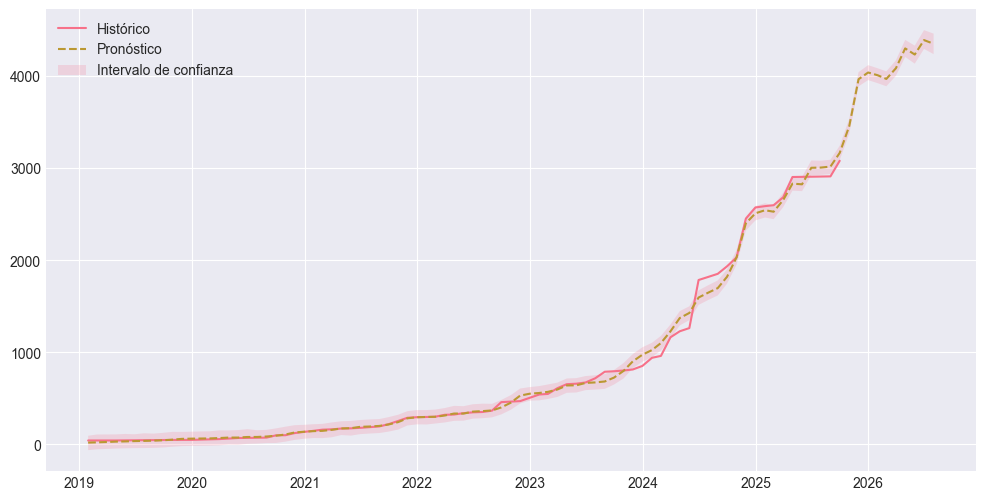

In [64]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(solar["ds"], solar["y"], label="Histórico")

ax.plot(forecast["ds"], forecast["yhat"], label="Pronóstico", linestyle="--")
ax.fill_between(
    forecast["ds"],
    forecast["yhat_lower"],
    forecast["yhat_upper"],
    alpha=0.2,
    label="Intervalo de confianza",
)

ax.legend()
ax.grid(True)
plt.show()


## **COMPARATIVA DE MODELOS**

In [ ]:
# ======================================================
# CALCULAR EL RMSE DE CADA MODELO
# ======================================================

# Crear DataFrame comparativo
rmse_comparison = pd.DataFrame({
    "Modelo": ["MODELO ETS VENTANA RECURSIVA", "MODELO ETS VENTANA MOVIL", "MODELO PROPHET VENTANA RECURSIVA", "MODELO PROPHET VENTANA MOVIL"],
    "RMSE": [rmse_hw_rec, rmse_hw_movil, rmse_pro_rec, rmse_pro_movil]
})

rmse_comparison

,Modelo,RMSE
0,MODELO ETS VENTANA RECURSIVA,161.777326
1,MODELO ETS VENTANA MOVIL,251.944713
2,MODELO PROPHET VENTANA RECURSIVA,227.481983
3,MODELO PROPHET VENTANA MOVIL,284.709154


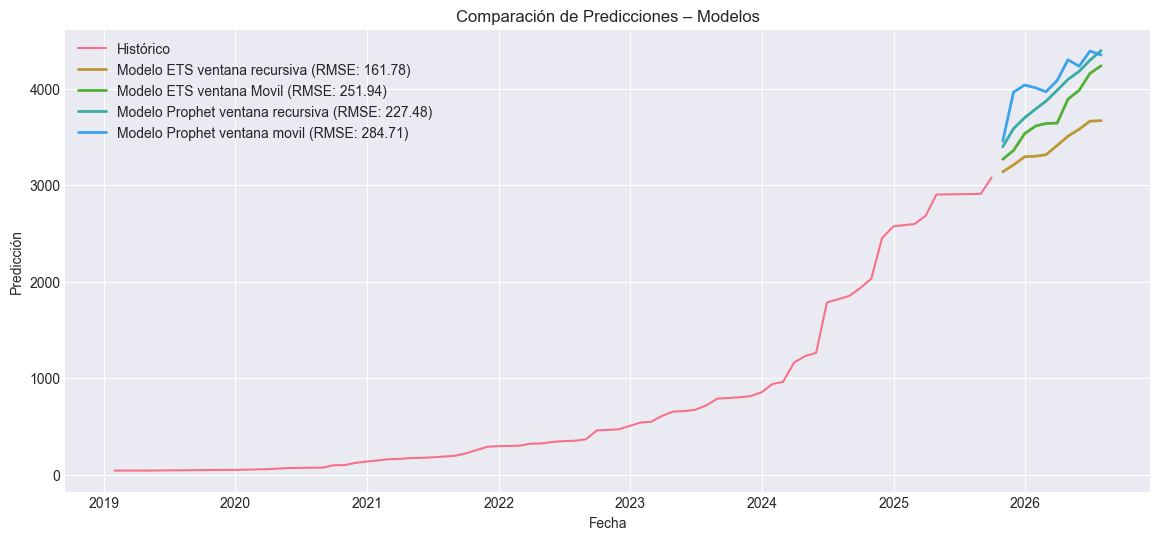

In [ ]:
# ======================================================
# GRAFICAS DE PREDICCIONES
# ======================================================

plt.figure(figsize=(14,6))

plt.plot(solar["ds"], solar["y"], label="Histórico")

# Modelo 1: 
plt.plot(
    forecast_10_rec_exp.index, 
    forecast_10_rec_exp.values, 
    label=f"Modelo ETS ventana recursiva (RMSE: {rmse_hw_rec:.2f})", 
    linewidth=2
)

# Modelo 2: 
plt.plot(
    forecast_10_mvoil_exp.index, 
    forecast_10_mvoil_exp.values, 
    label=f"Modelo ETS ventana Movil (RMSE: {rmse_hw_movil:.2f})",
    linewidth=2
)

# Modelo 3: 
plt.plot(
    forecast_10_rec['ds'], 
    forecast_10_rec['yhat'], 
    label=f"Modelo Prophet ventana recursiva (RMSE: {rmse_pro_rec:.2f})",
    linewidth=2
)
# Modelo 4:
plt.plot(
    forecast_10_movil['ds'], 
    forecast_10_movil['yhat'], 
    label=f"Modelo Prophet ventana movil (RMSE: {rmse_pro_movil:.2f})", 
    linewidth=2
)


plt.title("Comparación de Predicciones – Modelos")
plt.xlabel("Fecha")
plt.ylabel("Predicción")
plt.grid(True)
plt.legend()
plt.show()



## **CONCLUSIONES**

El modelo ETS con configuración trend = 'add', seasonal = 'add', seasonal_periods = 6 y damped_trend = False, 'alpha': 0.5392190745161005, 'beta': 0.29412865368036695, 'gamma': 0.22100350095940435. Evaluado mediante validación con ventana recursiva (expanding window), obtuvo el mejor desempeño entre todas las configuraciones probadas. Bajo este esquema, el modelo alcanzó un RMSE de 161.77, lo que indica una capacidad predictiva sólida para capturar tanto la tendencia creciente como la estacionalidad aditiva presente en la serie. Este resultado sugiere que la combinación de una tendencia aditiva con una dinámica estacional aditiva a seis periodos se ajusta de manera especialmente adecuada al comportamiento de la capacidad solar analizada, logrando proyecciones estables y consistentes en los distintos cortes temporales evaluados.